In [1]:
!pip install mysql-connector-python

In [2]:
import pandas as pd
import numpy as np
import mysql.connector

#connecting directly to the data warehouse where the information is stored
con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

In [3]:
#this action pulls data on the movie budget / revenue outcomes by film title
movie_budget = """SELECT id, release_date, movie, production_budget, domestic_gross, worldwide_gross 
FROM tn_movie_budgets ORDER BY worldwide_gross DESC; """
df = pd.read_sql_query(movie_budget, con)

In [4]:
# cleaning production budget into integers
df['production_budget'] = df['production_budget'].astype(str)
df['production_budget'] = df['production_budget'].str.replace(',', '')
df['production_budget'] = df['production_budget'].str.replace('$', '')
df['production_budget'] = df['production_budget'].astype(float)

In [5]:
# cleaning domestic gross into integers
df['domestic_gross'] = df['domestic_gross'].astype(str)
df['domestic_gross'] = df['domestic_gross'].str.replace(',', '')
df['domestic_gross'] = df['domestic_gross'].str.replace('$', '')
df['domestic_gross'] = df['domestic_gross'].astype(float)

In [6]:
# cleaning worldwide gross into integers
df['worldwide_gross'] = df['worldwide_gross'].astype(str)
df['worldwide_gross'] = df['worldwide_gross'].str.replace(',', '')
df['worldwide_gross'] = df['worldwide_gross'].str.replace('$', '')
df['worldwide_gross'] = df['worldwide_gross'].astype(float)

In [7]:
#create a new column that calculates MOIC
#MOIC - is a proxy value. worldwide gross does not reflect studio level cash flows
#sort by MOIC

df['MOIC'] = df['worldwide_gross'] / df['production_budget']

In [8]:
#convert date formats
pd.to_datetime(df['release_date']).head(1)

0   2009-08-21
Name: release_date, dtype: datetime64[ns]

In [9]:
#save changes to date formats.
df['release_date'] = pd.to_datetime(df['release_date'])

In [10]:
#create additional date variables
df['release_month'] = df['release_date'].apply(lambda x: x.month)
df['release_day'] = df['release_date'].apply(lambda x: x.weekday())
df['release_year'] = df['release_date'].apply(lambda x: x.year)

In [11]:
# Grab monthly movie count per month
month_counts = df.release_month.value_counts().append(
    pd.Series(df.shape[0], index=['Total']))

# Turns counts into a df and adds a column title
month_df = month_counts.to_frame()
month_df.columns = ['count']
month_df.index.name = 'release_month'

In [12]:
#drop total from dataframe
month_counts_bar = month_df.drop(index="Total", axis=0)

In [13]:
# Run this cell without changes

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [14]:
#this action pulls data on the crew (actors/actresses, directors and writers) by movie title
title_crew = """SELECT tconst, directors, writers FROM imdb_title_crew; """
df_crew = pd.read_sql_query(title_crew, con)

In [15]:
#this action pulls data on names of the crew members by a reference id#
name_basics = """SELECT nconst, primary_name, birth_year, death_year, primary_profession, known_for_titles FROM imdb_name_basics; """
df_names = pd.read_sql_query(name_basics, con)

In [16]:
#merge data on crew by title / names tied to reference id#
director_df = pd.merge(df_crew,
                       df_names, 
                       left_on = ['directors'],
                       right_on = ['nconst'],)

In [17]:
#pull data that identifies movie title by film id#
title_basics = """SELECT tconst, primary_title, original_title, start_year, genres FROM imdb_title_basics; """
df_title = pd.read_sql_query(title_basics, con)

In [18]:
#merge dataframe of director information and dataframe of movie titles using tconst as key
df_director_plus = pd.merge(director_df,
                       df_title, 
                       left_on = ['tconst'],
                       right_on = ['tconst'],)

In [19]:
df_budget_director = pd.merge(df,
                       df_director_plus, 
                       left_on = ['movie'],
                       right_on = ['original_title'],)

In [20]:
df_MOIC_sort = df_budget_director.sort_values(by=['MOIC'], ascending = False)

In [21]:
df_date_sort = df_budget_director.sort_values(by=['release_date'], ascending = True)

In [22]:
#converts data type from non-null object to datetime
pd.to_datetime(df_date_sort['release_date']).head()

2288   1915-02-08
2970   1927-08-12
100    1931-12-26
106    1933-04-07
2145   1937-12-21
Name: release_date, dtype: datetime64[ns]

In [23]:
#actually apply and save our changes
df_date_sort['release_date'] = pd.to_datetime(df_date_sort['release_date'])

In [24]:
df_release_date_index = df_date_sort.set_index(['release_date'])

In [25]:
df_release_date_index = df_date_sort.sort_values(by=['release_date'], ascending = False)

In [26]:
df_release_date_index.sort_values(by='MOIC', ascending=False)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,MOIC,release_month,release_day,release_year,...,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles,primary_title,original_title,start_year,genres
1726,47,1942-08-13,Bambi,858000.0,102797000.0,268000000.0,312.354312,8,3,1942,...,nm0509852,Sébastien Lifshitz,1968.0,NaN,"director,writer,actor","tt0156427,tt0364120,tt2668120,tt2399533",Bambi,Bambi,2013,"Biography,Documentary"
916,77,1968-10-01,Night of the Living Dead,114000.0,12087064.0,30087064.0,263.921614,10,1,1968,...,nm5209991,Chad Zuver,NaN,NaN,"producer,actor,writer","tt2645542,tt3645918,tt3393372,tt2666286",Night of the Living Dead,Night of the Living Dead,2014,Horror
1882,11,1976-11-21,Rocky,1000000.0,117235147.0,225000000.0,225.000000,11,6,1976,...,nm9645626,Adnan A. Shaikh,NaN,NaN,"director,writer,assistant_director","tt9430578,tt6843812",Rocky,Rocky,2019,"Action,Drama,Romance"
1881,11,1976-11-21,Rocky,1000000.0,117235147.0,225000000.0,225.000000,11,6,1976,...,nm1126847,Sujit Mondal,NaN,NaN,"assistant_director,director,writer","tt0247911,tt3080284,tt4773064,tt1443519",Rocky,Rocky,2013,"Action,Comedy,Drama"
350,37,1978-10-17,Halloween,325000.0,47000000.0,70000000.0,215.384615,10,1,1978,...,nm0337773,David Gordon Green,1975.0,NaN,"producer,director,writer","tt2195548,tt2382396,tt0262432,tt1502407",Halloween,Halloween,2018,"Horror,Thriller"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2976,90,2013-02-08,Small Apartments,2000000.0,0.0,0.0,0.000000,2,4,2013,...,nm0959774,Jonas Åkerlund,1965.0,NaN,"director,editor,writer","tt0283003,tt4139588,tt4669296,tt0348255",Small Apartments,Small Apartments,2012,"Comedy,Crime,Drama"
3123,56,2013-01-04,All Superheroes Must Die,20000.0,0.0,0.0,0.000000,1,4,2013,...,nm1875808,Jason Trost,NaN,NaN,"actor,writer,director","tt5428666,tt1836212,tt1296373,tt3466248",All Superheroes Must Die,All Superheroes Must Die,2011,"Sci-Fi,Thriller"
3048,2,2012-12-31,After,650000.0,0.0,0.0,0.000000,12,0,2012,...,nm4868383,Shaun Peter Cunningham,NaN,NaN,"producer,writer,editor","tt4688518,tt2886818,tt8692378,tt4572320",After,After,2018,Adventure
3109,13,2012-12-31,Hayride,60000.0,0.0,0.0,0.000000,12,0,2012,...,nm4363490,Terron R. Parsons,NaN,NaN,"producer,writer,director","tt2257696,tt2924352,tt3174376,tt1861343",Hayride,Hayride,2012,"Crime,Drama,Horror"


In [27]:
df_sort_MOIC_2 = df_release_date_index.sort_values(by='MOIC', ascending = False)

In [28]:
#filter for movies made after Jan 1 2013
netflix_era = '2013-01-01'
mask = (df_sort_MOIC_2['release_date'] > netflix_era)
df_1 = df_sort_MOIC_2.loc[mask]

In [29]:
#plot figure to show top 10 directors by MOIC since 2013
director_counts = df_1['primary_name'].value_counts()
director_list = director_counts[director_counts>2].index.tolist()
df_2 = df_1[df_1['primary_name'].isin(director_list)]

In [30]:
director_moic = df_2.groupby(by='primary_name').mean()['MOIC']

In [31]:
director_valuecounts = df_2.primary_name.value_counts()

In [32]:
director_df = pd.merge(director_valuecounts, director_moic, left_index=True, right_index=True)
director_df = director_df.rename(columns={'primary_name':'Movies_Directed'})

In [33]:
director_moic_rank = director_df.sort_values(by='MOIC', ascending = True)

In [34]:
director_moic_top10 = director_moic_rank.tail(10)

Text(0, 0.5, 'Global Revenue as MOIC')

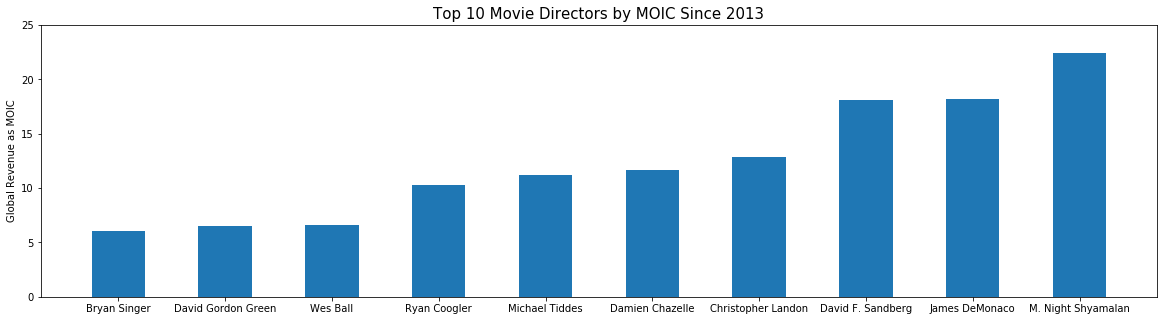

<Figure size 720x360 with 0 Axes>

In [35]:
#TOP 10 MOICs as a multiple of production budget by Movie Director

x_directors = director_moic_top10.index
y_moic = director_moic_top10.MOIC

fig, ax = plt.subplots(figsize=(20,5))
plt.figure(figsize=(10,5))
ax.set_ylim([0,25])
width = .5
ax.bar(x_directors, y_moic, width)
ax.set_title("Top 10 Movie Directors by MOIC Since 2013", fontsize=15)
ax.set_ylabel('Global Revenue as MOIC')